In [ ]:
SETTING={
    'REF_EXPERIMENT_INIT_WEIGHTS' : None, 
    'SEED_RANDOM':20201205,
    
    'OPTIMIZER': 'adam',#'SGD',#'rmsprop',#
    'LEARNING_RATE': 1E-05,
    'L2_REGULARIZATION': 1E-02,  


    'SGD_MOMENTUM': 0.9,
    'SGD_NESTEROV': True,

    'BATCH_SIZE': 10,#10,
    
    'IMG_HEIGHT': 135,#225,#256,#225,
    'IMG_WIDTH':  240,#400, #384, #400,

    'EPOCHS': 200,

    'DATASET': 'dataset_aug',#'casia_v2_github_gt',#'CASIA_V2_splitted', #'dataset_aug_20',#'dataset_aug',#'CASIA_V2_splitted', #'dataset_aug',

    'LOSS': 'binary_cross_entropy',

    'NORMALIZATION': 'gn',#'bn',#'gn',

    'MODEL': 'RRUNET',#'UNET_keras',

    'KERNEL_INITIALIZER': "pytorch",
    'BIAS_INITIALIZER': "pytorch"
}

# to be retrocompatible with older results
SETTING['ADAM_LEARNING_RATE'] = SETTING['LEARNING_RATE']
SETTING['SGD_LEARNING_RATE'] = SETTING['LEARNING_RATE']
SETTING['SGD_WEIGHT_DECAY'] = SETTING['L2_REGULARIZATION']

In [ ]:
import datetime
import json

REF_EXPERIMENT = {
    "ID": datetime.datetime.now().strftime("%m%d-%H%M"),
    "OPT": SETTING['OPTIMIZER'],
    "LR" : "{:.2e}".format(SETTING['LEARNING_RATE']),
    "L2" : "{:.2e}".format(SETTING['L2_REGULARIZATION']),
    "K_INIT":  SETTING['KERNEL_INITIALIZER'],
    "B_INIT": SETTING['BIAS_INITIALIZER'],
    "DATASET" : SETTING['DATASET'],
    "NORM": SETTING['NORMALIZATION']
}
REF_EXPERIMENT = json.dumps(REF_EXPERIMENT).replace(" ", "")
REF_EXPERIMENT

'{"ID":"1206-1322","OPT":"adam","LR":"1.00e-05","L2":"1.00e-02","K_INIT":"pytorch","B_INIT":"pytorch","DATASET":"dataset_aug","NORM":"gn"}'

In [ ]:
!nvidia-smi

Mon Dec  6 13:22:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
SETTING['OPTIMIZER'], SETTING['LEARNING_RATE']

('adam', 1e-05)

In [ ]:
from google.colab import drive

MOUNT_POINT = '/content/gdrive' 
drive.mount(MOUNT_POINT,  force_remount=True)
MOUNT_POINT += "/My Drive"

Mounted at /content/gdrive


In [ ]:
!pip install icecream
from icecream import ic

import os
import json
import matplotlib.pyplot as plt
!pip install tensorflow-io

     |████████████████████████████████| 22.7 MB 1.6 MB/s 


In [ ]:
#folders
PWD = os.path.join(MOUNT_POINT, "4.2/visiope/PROJECT")

#input dataset
DATASET_ROOT_IMAGE = os.path.join(PWD, SETTING['DATASET'], 'images')

## TRAIN
TRAINING_SET_IMAGE = os.path.join(DATASET_ROOT_IMAGE, 'train/images')

## VALIDATION
VALIDATION_SET_IMAGE = os.path.join(DATASET_ROOT_IMAGE, 'val/images')

## TEST
TEST_SET_IMAGE = os.path.join(DATASET_ROOT_IMAGE, 'test/images')

In [ ]:
#export result
EXPORT_ROOT = os.path.join(PWD, 'results')
if not os.path.isdir(EXPORT_ROOT):
  os.makedirs(EXPORT_ROOT)
EXPORT_CURRENT_EXPERIMENT = os.path.join(EXPORT_ROOT, REF_EXPERIMENT)

In [ ]:
SETUPS = os.path.join(EXPORT_CURRENT_EXPERIMENT, 'setups')
MODELS = os.path.join(EXPORT_CURRENT_EXPERIMENT, 'models')
LOG_TRAINING_TESTING = os.path.join(EXPORT_CURRENT_EXPERIMENT, 'log_training_testing')
BEST_WEIGHTS = os.path.join(EXPORT_CURRENT_EXPERIMENT, 'weights')

LOGS = os.path.join(EXPORT_CURRENT_EXPERIMENT, 'logs')

CHECKPOINT = os.path.join(EXPORT_CURRENT_EXPERIMENT, 'checkpoint')

In [ ]:
if os.path.isdir(EXPORT_CURRENT_EXPERIMENT):
  print("Error! Current experiment has been already performed, change REF_EXPERIMENT to run a new experiment")
  raise KeyboardInterrupt
else:
  os.makedirs(SETUPS)
  os.makedirs(MODELS)
  os.makedirs(LOG_TRAINING_TESTING)
  os.makedirs(BEST_WEIGHTS)
  os.makedirs(LOGS)
  os.makedirs(CHECKPOINT)

In [ ]:
def save_as_json(filename, dictionary):
  with open(filename, "w") as outfile:
      json.dump(dictionary, outfile, indent=4)
      outfile.close()

def load_from_json(filename):
  res = {}
  with open(filename, "r") as infile:
    res=json.load(infile)
    infile.close()
  return res

In [ ]:
def export_setting(name_setting, setting):
  #export setting
  filename = os.path.join(SETUPS, name_setting)
  with open(filename, "w") as outfile:
      json.dump(setting, outfile, indent=4)
      outfile.close()

def load_setting(name_setting):
    #import setting
    filename = os.path.join(SETUPS, name_setting)
    setting = {}
    with open(filename, "r") as infile:
        setting=json.load(infile)
        infile.close()
    return setting

In [ ]:
export_setting('SETTING.json', SETTING)

# RRU-Net

In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [ ]:
import numpy as np
import tensorflow as tf

import keras

print("Tensorflow version %s" %tf.__version__)
print("Keras version %s" %keras.__version__)

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.7.0
Keras version 2.7.0


In [ ]:
import sys
sys.path.append(PWD)

import RRU_net
import Dataset
import Utils
import Evaluation
import Losses

In [ ]:
#set seeds
from numpy.random import seed 
seed(SETTING['SEED_RANDOM'])

tf.random.set_seed(SETTING['SEED_RANDOM'])

# MODEL

In [ ]:
from tensorflow.keras import layers



In [ ]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

if SETTING['MODEL'] == 'RRUNET':
  model = RRU_net.RRU_net(l2_penalty=SETTING['SGD_WEIGHT_DECAY'],
                            normalization=SETTING['NORMALIZATION'],
                            kernel_initializer=SETTING['KERNEL_INITIALIZER'],
                            bias_initializer=SETTING['BIAS_INITIALIZER'],
                            seed_initializer=SETTING['SEED_RANDOM']                          
                          )
  input_x = tf.random.uniform((1, 6, 14, 3))
  y_hat = model(input_x)
  model.summary()
else:
  model = None

Model: "rru_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 down_0 (RRU_first_down)     multiple                  10528     
                                                                 
 down_1 (RRU_down)           multiple                  59904     
                                                                 
 down_2 (RRU_down)           multiple                  238592    
                                                                 
 down_3 (RRU_down)           multiple                  952320    
                                                                 
 down_4 (RRU_down)           multiple                  1312768   
                                                                 
 up_1 (RRU_up)               multiple                  1132288   
                                                                 
 up_2 (RRU_up)               multiple                  2835

# Dataset

In [ ]:
dataset_builder = Dataset.Dataset(training_image_folder=TRAINING_SET_IMAGE,
                                  validation_image_folder=VALIDATION_SET_IMAGE, 
                                  batch_size=SETTING['BATCH_SIZE'], 
                                  random_seed=SETTING['SEED_RANDOM'],
                                  img_height=SETTING['IMG_HEIGHT'],
                                  img_width=SETTING['IMG_WIDTH'])

None
Tensor("case/cond/Identity:0", shape=(), dtype=string)
None
Tensor("case/cond/Identity:0", shape=(), dtype=string)


In [ ]:
dataset = dataset_builder.dataset

TRAINSET_SIZE = dataset_builder.training_set_size
VALSET_SIZE = dataset_builder.validation_set_size

In [ ]:
print(dataset['train'])
print(dataset['val'])

<PrefetchDataset shapes: ((None, 135, 240, None), (None, 135, 240, 1)), types: (tf.float32, tf.uint8)>
<PrefetchDataset shapes: ((None, 135, 240, None), (None, 135, 240, 1)), types: (tf.float32, tf.uint8)>


###Example

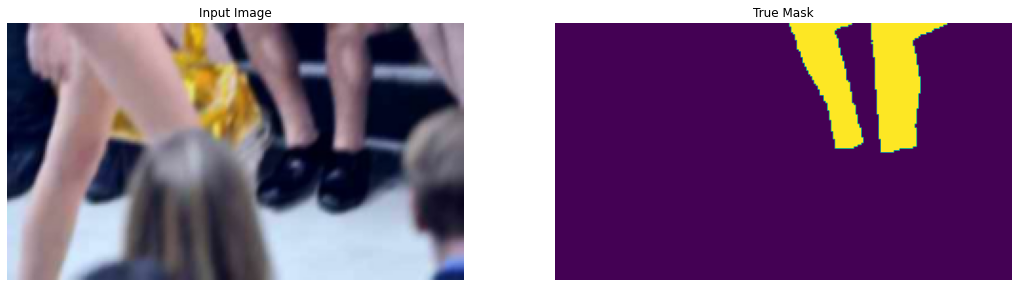

In [ ]:
def display_sample(display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

display_sample([sample_image[0], sample_mask[0]])

#TEST PREDICTION

In [ ]:
def create_mask(prediction: tf.Tensor):
  threshold = 0.5
  res = tf.math.greater(prediction, threshold)
  res = tf.cast(res, tf.uint8)*255
  return res

In [ ]:
def mask_to_PIL_image(mask: tf.Tensor):
  img = tf.keras.preprocessing.image.array_to_img(mask)
  return img

In [ ]:
def prediction_to_PIL_image_mask(prediction: tf.Tensor):
  mask = create_mask(prediction)
  return mask_to_PIL_image(mask)

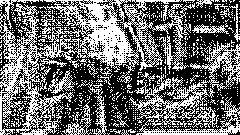

In [ ]:
img_in = sample_image
pred = model.predict(img_in)
prediction_to_PIL_image_mask(pred[0])

In [ ]:
def show_predictions(dataset=None, num=1):
  for images, masks in dataset.take(num):
      pred_masks = model.predict(images)

      for i in range(len(images)):      
        pred_mask = create_mask(pred_masks[i])
        true_mask = masks[i]
        display_sample([images[i], true_mask, pred_mask])

show_predictions(dataset['val'])

# EVALUATION

In [ ]:
def eval_val():
  return Evaluation.evaluation(model, dataset['val'], VALSET_SIZE, SETTING['BATCH_SIZE'])

## LOSS

In [ ]:
def loss_example(image, true_mask):
  pred = model.predict(image)
  return Losses.binary_cross_entropy_flatten(true_mask, pred)


for image, mask in dataset['train'].take(1):
  sample_image, sample_mask = image, mask

ic(loss_example(sample_image, sample_mask));

ic| loss_example(sample_image, sample_mask): <tf.Tensor: shape=(), dtype=float32, numpy=0.72851604>


# TRANING

In [ ]:
init_weight_path = None
if SETTING['REF_EXPERIMENT_INIT_WEIGHTS'] != None:
  tmp = os.path.join(EXPORT_ROOT, SETTING['REF_EXPERIMENT_INIT_WEIGHTS'])
  INIT_WEIGHTS = os.path.join(tmp, 'weights')
  
  for filename in sorted(os.listdir(INIT_WEIGHTS), reverse=True):
    if 'f1_score' in filename:
      init_weight_path = os.path.join(INIT_WEIGHTS, filename)
      break

init_weight_path

In [ ]:
if SETTING['REF_EXPERIMENT_INIT_WEIGHTS'] != None:
  Utils.load_weights(model, init_weight_path)

In [ ]:
if SETTING['REF_EXPERIMENT_INIT_WEIGHTS'] != None: 
  eval_val()

In [ ]:
#Utils.save_weights(model, os.path.join(BEST_WEIGHTS, 'PRE_TRAINING'))

In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import Recall, Accuracy   

if SETTING['OPTIMIZER'] == 'SGD':
  opt = tf.keras.optimizers.SGD(
                                learning_rate=SETTING['SGD_LEARNING_RATE'], 
                                momentum=SETTING['SGD_MOMENTUM'], 
                                nesterov=SETTING['SGD_NESTEROV'], name="SGD")
elif SETTING['OPTIMIZER'] == 'adam':
  opt = tf.keras.optimizers.Adam(learning_rate=SETTING['ADAM_LEARNING_RATE'])
  print("adam opt")
elif SETTING['OPTIMIZER'] == 'rmsprop':
  opt = tf.keras.optimizers.RMSprop(
    learning_rate=SETTING['LEARNING_RATE'], rho=0.9, momentum=0.0, epsilon=1e-07, centered=False, name='RMSprop')
  print("rmsprop opt")
else:
  opt = SETTING['OPTIMIZER']
  print("warning unexpeted opt: " + opt)

if SETTING['LOSS'] == 'binary_cross_entropy':
  loss = Losses.binary_cross_entropy_flatten
elif SETTING['LOSS'] == 'dice_loss':
  loss = Losses.dice_loss_flatten
else:
  raise SystemError('Unknown loss function!')

model.compile(optimizer=opt, loss=loss)

adam opt


In [ ]:
import datetime

logdir = os.path.join(LOGS, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

file_writer = tf.summary.create_file_writer(os.path.join(logdir, 'metrics'))
file_writer.set_as_default() 

In [ ]:
EPOCHS = SETTING['EPOCHS']

STEPS_PER_EPOCH = TRAINSET_SIZE // SETTING['BATCH_SIZE']
VALIDATION_STEPS = VALSET_SIZE // SETTING['BATCH_SIZE']

In [ ]:
model_history = model.fit(dataset['train'], 
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=dataset['val'],
                          verbose=1, 
                          callbacks=[
                                     Evaluation.evaluation_save_best_weigths(
                                             _valid_data=dataset['val'], 
                                             _val_size=VALSET_SIZE, 
                                             _batch_size=SETTING['BATCH_SIZE'],
                                             _SETTING=SETTING,
                                             _BEST_WEIGHTS=BEST_WEIGHTS, 
                                             _CHECKPOINT=CHECKPOINT
                                             ),
                                     tensorboard_callback                                     
                                     ]
                          )

Epoch 1/200
192/192 [==============================] - 539s 3s/step - loss: 15.5837 - val_loss: 14.5705 - val_f1: 0.2003 - val_recall: 0.1835 - val_precision: 0.2204 - val_dice_loss: 0.2574
Epoch 2/200
192/192 [==============================] - 70s 365ms/step - loss: 13.6985 - val_loss: 12.8527 - val_f1: 0.1179 - val_recall: 0.0806 - val_precision: 0.2194 - val_dice_loss: 0.2521
Epoch 3/200
192/192 [==============================] - 70s 366ms/step - loss: 12.1271 - val_loss: 11.4110 - val_f1: 0.0779 - val_recall: 0.0475 - val_precision: 0.2163 - val_dice_loss: 0.2407
Epoch 4/200
192/192 [==============================] - 70s 363ms/step - loss: 10.8017 - val_loss: 10.1896 - val_f1: 0.0592 - val_recall: 0.0341 - val_precision: 0.2264 - val_dice_loss: 0.2399
Epoch 5/200
192/192 [==============================] - 70s 365ms/step - loss: 9.6761 - val_loss: 9.1504 - val_f1: 0.0475 - val_recall: 0.0264 - val_precision: 0.2379 - val_dice_loss: 0.2301
Epoch 6/200
192/192 [=======================

In [ ]:
history_filename = os.path.join(LOG_TRAINING_TESTING, 'HISTORY.txt')
with open(history_filename, "w") as outfile:
    outfile.write(str(model_history.history))
    outfile.close()

In [ ]:
drive.flush_and_unmount() 

Drive not mounted, so nothing to flush and unmount.
